In [2]:
import DeepMIMO
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
from scipy.io import loadmat, savemat 
import glob
import re 

plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size

In [8]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):
    
    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate
    
    vecs = []
    for dim in range(3):
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))                                                                                                     
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)
        
    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))
    
    return F

In [9]:
parameters = DeepMIMO.default_params()


# # Change parameters for the setup
# Scenario O1_60 extracted at the dataset_folder
parameters['scenario'] = 'O1_60'
parameters['dataset_folder'] = 'dataset/scenarios' # Set DeepMIMO dataset folder that has O1_60

parameters['num_paths'] = 5

# User rows 1-100
parameters['user_row_first'] = 1000
parameters['user_row_last'] = 1030

# Activate only the first basestation
parameters['active_BS'] = np.array([3, 4, 5, 6])

parameters['OFDM']['bandwidth'] = 0.5 # 50 MHz
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 512 subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna
parameters['bs_antenna']['shape'] = np.array([1, 32, 8]) # ULA of 32 elements
parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'


dataset = DeepMIMO.generate_data(parameters)


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 5611/5611 [00:01<00:00, 3887.17it/s]



Basestation 4

UE-BS Channels


Generating channels: 100%|██████████| 5611/5611 [00:01<00:00, 3921.44it/s]



Basestation 5

UE-BS Channels


Generating channels: 100%|██████████| 5611/5611 [00:02<00:00, 2672.42it/s]



Basestation 6

UE-BS Channels


Generating channels: 100%|██████████| 5611/5611 [00:02<00:00, 2397.64it/s]


In [10]:
#%% Parameters and Codebook
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])

NF = 5             # Noise figure at the base station
Process_Gain = 10  # Channel estimation processing gain
BW = parameters['OFDM']['bandwidth'] * 1e9 # System bandwidth in Hz
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain; # Noise power in dB
noise_power = 10**(.1*(noise_power_dB)); # Noise power

In [11]:
#%% DL Input-Output
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))
for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
    for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS-%i'%bs_idx, position=0, leave=True):
        ch = dataset[bs_idx]['user']['channel'][ue_idx].squeeze()
        ch = ch + np.sqrt(noise_power) * (np.random.randn(*(ch.shape)) + 1j * np.random.randn(*(ch.shape)))
        input_norm[bs_idx, ue_idx, :] = ch[0, :]
        max_rates[bs_idx, ue_idx, :] = np.sum(np.log2(1 + np.abs(ch.T.conj() @ F)**2),  axis = 0)/num_OFDM
        
# Input reshape - normalize
input_norm = np.transpose(input_norm, axes=[1, 0, 2])
input_norm = input_norm.reshape((num_ue, -1))
input_norm /=  np.amax(np.abs(input_norm))

# Output reshape - normalize
max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
max_rates_norm_factor[max_rates_norm_factor== 0] = 1 # Do not normalize if all zeros
max_rates /= max_rates_norm_factor
max_rates = np.transpose(max_rates, axes=[1, 0, 2])
max_rates = max_rates.reshape((num_ue, -1))

if not os.path.exists('./DLCB_dataset'):
                      os.makedirs('DLCB_dataset')
savemat('./DLCB_dataset/DLCB_input.mat', {'DL_input': input_norm})
savemat('./DLCB_dataset/DLCB_output.mat', {'DL_output': max_rates})

Neural Network Input-Output Generation-BS: 100%|██████████| 4/4 [00:38<00:00,  9.61s/it]


In [12]:
input_norm.shape

(5611, 256)

In [13]:
import os
import keras
import keras.models as models
from keras.layers import Dense, Dropout
# from keras.layers.core import Dense,Dropout
import numpy as np

In [16]:
# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    for bs_idx in range(n_BS):
        idx_str = 'BS%i' % bs_idx
        idx = bs_idx*n_beams
        
        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
        model.add(Dropout(dr))
        for h in range(num_hidden_layers):
            model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dr))
        
        model.add(Dense(n_beams, activation='relu', kernel_initializer='he_normal',
                  name="dense" + idx_str + "o"))
        model.compile(loss=loss_fn, optimizer='adam')
        # model.summary()
    
        model.fit(In_train,
                    Out_train[:, idx:idx + n_beams],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                    callbacks = [
                        #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])
        
        AP_models.append(model)
        
        
    return AP_models


In [17]:
# Reading input and output sets generated from MATLAB
In_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
Out_set_file=loadmat('DLCB_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[0.001, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7]
count=0
num_tot_TX=4
num_beams=512

for DL_size_ratio in n_DL_size:
    
    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)
    
    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)
    
    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))
    
    In_train = In_set[train_index]
    In_test =  In_set[test_index] 
        
    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]
    
    
    # Learning model parameters
    epochs = 10     
    batch_size = 100  
    dr = 0.05                  # dropout rate  
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'
    
    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          epochs, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,num_beams)

    
    # Model running/testing
    DL_Result={}
    for idx in range(0,num_tot_TX,1): 
        beams_predicted=AP_models[idx].predict( In_test, batch_size=10, verbose=0)
    
        DL_Result['TX'+str(idx+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(idx+1)+'Opt_Beams']=Out_test[:,idx*num_beams:(idx+1)*num_beams]

    DL_Result['user_index']=test_index
    
    
    if not os.path.exists('./DLCB_code_output'):
                          os.makedirs('DLCB_code_output')
    savemat('DLCB_code_output/DL_Result'+str(count)+'.mat',DL_Result)


0.001
Epoch 1/10
1/1 - 1s - 891ms/step - loss: 0.0741 - val_loss: 0.0273
Epoch 2/10
1/1 - 0s - 43ms/step - loss: 0.0251 - val_loss: 0.0162
Epoch 3/10
1/1 - 0s - 40ms/step - loss: 0.0099 - val_loss: 0.0110
Epoch 4/10
1/1 - 0s - 42ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 5/10
1/1 - 0s - 54ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 6/10
1/1 - 0s - 94ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 7/10
1/1 - 0s - 46ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 8/10
1/1 - 0s - 40ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 9/10
1/1 - 0s - 40ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 10/10
1/1 - 0s - 38ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 1/10
1/1 - 1s - 801ms/step - loss: 0.0493 - val_loss: 0.0185
Epoch 2/10
1/1 - 0s - 41ms/step - loss: 0.0153 - val_loss: 0.0118
Epoch 3/10
1/1 - 0s - 37ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 4/10
1/1 - 0s - 38ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 5/10
1/1 - 0s - 41ms/step - loss: 0.0045 - val_loss: 0.0059
E

In [18]:
file_list = sorted(glob.glob('DLCB_code_output/DL_Result*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
num_files = len(file_list)

user_index = []
pred_beams = []
opt_beams = []
for file in tqdm(file_list, desc='Reading DL results'):
    matfile = loadmat(file)
    l1 = []
    l2 = []
    for idx in range(num_bs):
        l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
        l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])
        
    pred_beams.append(l1)
    opt_beams.append(l2)
    user_index.append(matfile['user_index'])


Pn = -204 + 10*np.log10(BW) # Noise power in dB
SNR = 10**(.1*(0-Pn))

ach_rate_DL = np.zeros(num_files)
ach_rate_opt = np.zeros(num_files)

eff_rate = np.zeros(num_files)
opt_rate = np.zeros(num_files)
for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
    user_index_file = user_index[file_idx].flatten()
    for ue_idx in range(len(user_index_file)):
        eff_ch = []
        opt_ch = []
        for bs_idx in range(num_bs):
            if file_idx == 0: # Random BF - 0 Samples
                pred_beam_idx = np.random.randint(num_beams)
            else:
                pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
            opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
            ch_single_bs = dataset[bs_idx]['user']['channel'][user_index_file[ue_idx]].squeeze()
            eff_ch_single_pred = ch_single_bs.T.conj() @ F[:, pred_beam_idx]
            opt_ch_single_pred = ch_single_bs.T.conj() @ F[:, opt_beam_idx]
            eff_ch.append(eff_ch_single_pred)
            opt_ch.append(opt_ch_single_pred)
        eff_ch = np.array(eff_ch)
        opt_ch = np.array(opt_ch)
        eff_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(eff_ch.conj().T @ eff_ch))))
        opt_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(opt_ch.conj().T @ opt_ch))))
    eff_rate[file_idx] /= len(user_index_file)*num_OFDM
    opt_rate[file_idx] /= len(user_index_file)*num_OFDM

Calculating results: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


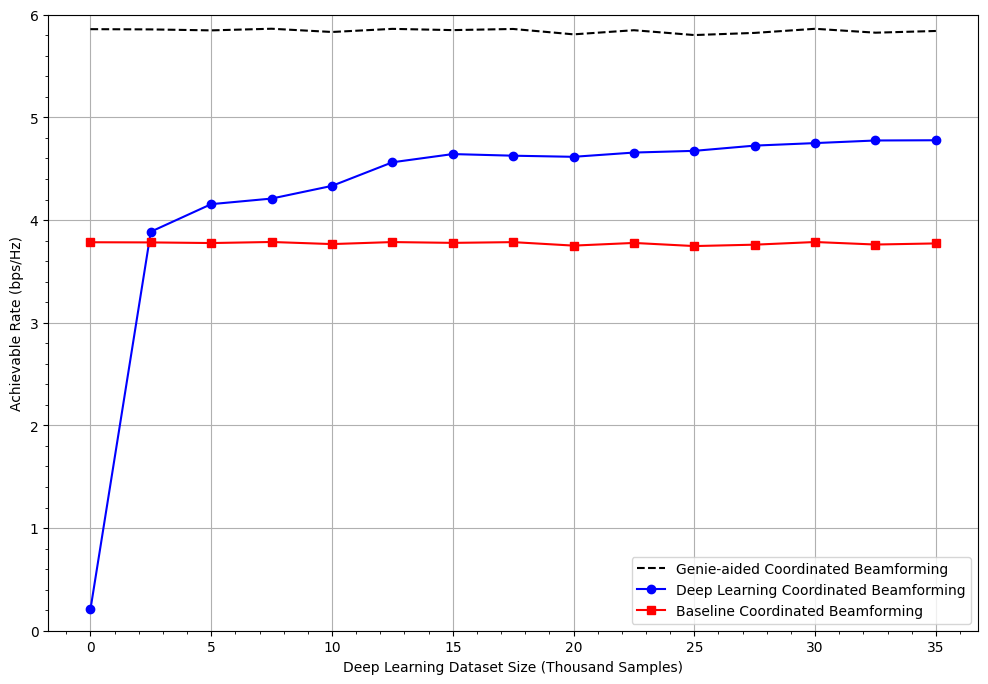

In [ ]:
theta_user=(102/parameters['bs_antenna'][0]['shape'][1])*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method

#%% Plotting the figure
DL_size_array=np.arange(0, 2.5*(num_files), 2.5)

fig, ax = plt.subplots()
plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided Coordinated Beamforming')
plt.plot(DL_size_array, eff_rate*overhead_DL, '-bo', label = 'Deep Learning Coordinated Beamforming')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline Coordinated Beamforming')
plt.ylim([0, 6])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')